In [1]:
import pandas as pd
import copy

input_file_name = "input.json"
import json
with open(input_file_name) as f:
  input_data = json.load(f)
input_data = input_data["data"]

# Optional extra parameters
if "extra_arguments" in input_data:
    extra_arguments = input_data['extra_arguments']
else:
    extra_arguments = {}

if "solver_params" in input_data:
    solver_params = input_data['solver_params']
else:
    solver_params = {}


from_=input_data['from']
to_=input_data['to']
assets=input_data['assets']
dfs=[]
for asset in assets:
    dfs.append(pd.Series(assets[asset]['history'],name=asset))
df=pd.concat(dfs,axis=1).bfill().pct_change()
ini=1
results={}
results[max([x for x in df.index.tolist() if x<from_])]=ini
for t in [ x for x in df.index.tolist() if x>=from_ and x<=to_]:
    d={}
    d['num_assets']=input_data['num_assets']
    assets_=copy.deepcopy(assets)
    for asset in assets_:
        assets_[asset]['history']={x:assets_[asset]['history'][x] for x in assets_[asset]['history'] if x<t}
    d['assets']=assets_
    d['evaluation_date']=t

In [2]:
"""
    Our code starts here. d is the only input to the "portfolio.py". Takes 'budget'
"""

# Budget how?!?!?!?
# budget = d["solver_params"]["budget"]

B = 400 
filtering_number = 5

L = d['num_assets']
asset_names = list(d["assets"].keys())
p = [list(d['assets'][name]['history'].values()) for name in asset_names] # Stock prices over time
P = [p[i][-1] for i in range(L)] # Current Stock Prices

In [3]:
import numpy as np

# Expected Return:
r = [[(p[i][t]-p[i][t-1])/p[i][t-1] if t>0 else 0 for t in range(len(p[i]))] for i in range(len(p))]
mu = []
for i in range(L):
    exp = np.sum(np.array([r[i][t] for t in range(len(r[i]))])) / len(r[i])
    if not np.isnan(exp):
        mu.append(exp)
    else:
        mu.append(-100)


# We take only the highest 10 expected returns and will optimize over them.
# This can be user defined parameter. As the quantum computer scales up,
# we'll be able to increase this number.
indices = np.argsort(mu)
mu_filtered = []
r_filtered = []
p_filtered = []
for index in indices[-filtering_number:]:
    mu_filtered.append(mu[index])
    r_filtered.append(r[index])
    p_filtered.append(p[index])

mu = mu_filtered
r = r_filtered
L = filtering_number
p = p_filtered

# Variance Matrix:

Sigma = [
    [   np.sum(np.array([
        (r[i][t]-mu[i])*(r[j][t]-mu[j]) for t in range( min( len(r[i]),  len(r[j])) )
    ]))/(len(r[i]) - 1)
        for j in range(L)
    ] for i in range(L)
]

P_p = [P[i]/B for i in range(L)]
mu_p = [mu[i]*P_p[i] for i in range(L)]
Sigma_p = [[P_p[i]*P_p[j]*Sigma[i][j] for j in range(L)] for i in range(L)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


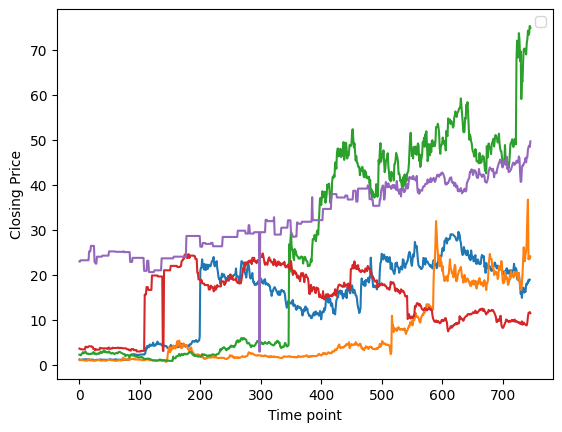

In [4]:
import matplotlib.pyplot as plt

for i in range(L):
    plt.plot(p[i])
plt.legend()
plt.xlabel("Time point")
plt.ylabel("Closing Price")
plt.show()

In [5]:
# Ising Implementation:

q = 1 # Risk aversion factor.
lamb = 10 # Budget penalty param.
n_max = [np.floor(B/P[i]) for i in range(L)]

D = [np.ceil(np.log(n_max[i])/np.log(2)) for i in range(L)]
N = int(np.sum(np.array(D))) # Number of dimensions of vector b.

C = [[] for i in range(L)]
for i in range(L):
    for j in range(i):
        C[i] += [0]*int(D[j])
    C[i] += [2**d for d in range(int(D[i]))]
    for j in range(i+1, L):
        C[i] += [0]*int(D[j])
C = np.array(C)

mu_pp = C.T @ mu_p
Sigma_pp = C.T @ Sigma_p @ C
P_pp = C.T @ P_p


Sigma_pp = np.array(Sigma_pp)
J = q/4 * Sigma_pp
h = [-0.5*mu_pp[i] + 0.5*q*(Sigma_pp@np.array([1 for j in range(N)]))[i] for i in range(N)]
pi = [P_pp[i]/2 for i in range(N)]
beta = 1 - np.sum(np.array([P_pp[i]/2 for i in range(N)]))

In [6]:
# Cost Function for the classical optimization, binary formulation.
# Classical Optimization
from scipy.optimize import brute

def classical_cost_b(b, q, lamb, mu_pp, Sigma_pp, P_pp):
    return -(np.dot(mu_pp, b) - q * np.dot(b, Sigma_pp @ b) - lamb*(np.dot(P_pp, b) - 1)**2)

ranges = [slice(0, 2, 1) for i in range(N)]
binary_result = brute(lambda b: classical_cost_b(b, q, lamb, mu_pp, Sigma_pp, P_pp), ranges, disp=True, finish=None)
result = C@binary_result
B_spent = np.sum(np.array([result[i]*P[i] for i in range(L)]))

print("Budget Spent: ", B_spent)
print("Optimal Portfolio: ", result)

Budget Spent:  400.78998827934265
Optimal Portfolio:  [18.  2.  0. 15.  0.]


In [7]:
N

18

In [ ]:
from scipy.sparse import linalg as LA
import scipy.sparse as sp

Z = np.array([[1.,  0.], [0., -1.]])
I = sp.identity(2, format='csr')

hamil1 = 0 * sp.csr_matrix((2**N, 2**N))
for i in range(N):
    for j in range(N):
        Z_exp1 = sp.eye(1)
        for _ in range(i):
            Z_exp1 = sp.kron(Z_exp1, I)
        Z_exp1 = sp.kron(Z_exp1, Z)
        for _ in range(i+1, N):
            Z_exp1 = sp.kron(Z_exp1, I)

        Z_exp2 = sp.eye(1)
        for _ in range(j):
            Z_exp2 = sp.kron(Z_exp2, I)
        Z_exp2 = sp.kron(Z_exp2, Z)
        for _ in range(j+1, N):
            Z_exp2 = sp.kron(Z_exp2, I)
        Z_exp = Z_exp1 @ Z_exp2
        hamil1 = hamil1 + J[i][j] * Z_exp


hamil2 = 0 * sp.csr_matrix((2**N, 2**N))
for i in range(N):
    Z_exp = sp.eye(1)
    for _ in range(i):
        Z_exp = sp.kron(Z_exp, I)
    Z_exp = sp.kron(Z_exp, Z)
    for _ in range(i+1, N):
        Z_exp = sp.kron(Z_exp, I)
    hamil2 = hamil2 + h[i] * Z_exp
hamil = hamil1 + hamil2


penal = 0 * sp.csr_matrix((2**N, 2**N))
for i in range(N):
    Z_exp = sp.eye(1)
    for _ in range(i):
        Z_exp = sp.kron(Z_exp, I)
    Z_exp = sp.kron(Z_exp, Z)
    for _ in range(i+1, N):
        Z_exp = sp.kron(Z_exp, I)
    penal = penal + pi[i] * Z_exp
penal = penal - beta * sp.identity(2**N, format='csr')
penal = penal @ penal
hamil = hamil + lamb * penal

In [ ]:
eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy: ", eigenvalues_sort[0])
print("First Excited Energy: ", eigenvalues_sort[1])
print("Highest Energy: ", eigenvalues_sort[-1])

i = 0
for comp in ground_state:
    if comp == 1:
        break
    else:
        i = i+1

b_Ising = []
for ch in bin(i)[2:]:
    b_Ising.append(0 if ch == '1' else 1)
b_Ising = np.array(b_Ising)

print("Optimal Portfolio: ", C@b_Ising)